In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import import_ipynb
import Lib.Functions as fc
import Lib.Feature_Selection as ft
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Functions.ipynb
importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Feature_Selection.ipynb


In [2]:
demographics = pd.read_csv('ICKDemographicsPipeline_v260423.csv')
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173193 entries, 0 to 173192
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   UserID          173193 non-null  object 
 1   TotalChild      173193 non-null  int64  
 2   MedianChildAge  173193 non-null  float64
 3   No.Female       173193 non-null  float64
 4   No.Male         173193 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.6+ MB


In [3]:
df_pay = pd.read_csv('RealPaymentsType.csv')
df_pay['UserJoinedDate'] = df_pay['UserJoinedDate'].map(lambda x: x[: 19])
df_pay['UserJoinedDate'] = pd.to_datetime(df_pay['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')
df_pay['JoinMonth'] = df_pay['UserJoinedDate'].dt.month

payment = df_pay[['UserID', 'UserJoinedDate', 'gapday']]
payment.shape

(265308, 3)

In [4]:
detail = pd.read_csv('Engagement_detail_learn_updated.csv')
detail['InteractionLearn'] = detail['UsageTime'] * detail['Records']

detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506702 entries, 0 to 1506701
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   EventDate                  1506702 non-null  object 
 1   nth_day_from_registration  1506702 non-null  int64  
 2   UserID                     1506702 non-null  object 
 3   SubjectName                1506702 non-null  object 
 4   IsCompleted                1506702 non-null  int64  
 5   UsageTime                  1506702 non-null  float64
 6   Records                    1506702 non-null  int64  
 7   InteractionLearn           1506702 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 92.0+ MB


In [5]:
detail = pd.merge(left=detail,
                  right=payment,
                  how='left',
                  on='UserID')
detail.shape

(1506702, 10)

In [6]:
firstday_learn = pd.DataFrame(detail.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday_learn.columns = ['UserID', 'MinFirstDay']

firstday_learn['ZeroDay'] = firstday_learn['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday_learn.shape

(153340, 3)

In [7]:
detail = pd.merge(left=detail,
                  right=firstday_learn,
                  how='left',
                  on='UserID')

detail.loc[detail['gapday'].isnull(), 'gapday'] = 'no_pay'
detail.shape

(1506702, 12)

In [8]:
def DetailBasedNthDay(dataframe, nthday=6):
    pay = dataframe.loc[dataframe['gapday'] != 'no_pay']
    
    mask0 = pay['ZeroDay'] == 'zero'
    mask1 = pay['nth_day_from_registration'] <= nthday
    df0 = pay[mask0 & mask1]
    
    df0['CutoffDay'] = df0['MinFirstDay'] + nthday
    df0['ScaleActionDay'] = df0['nth_day_from_registration'] - 0
    df0['ScaleGapday'] = df0['gapday'] - df0['MinFirstDay']
    
    mask2 = pay['ZeroDay'] != 'zero'
    others = pay[mask2]
    others['CutoffDay'] = others['MinFirstDay'] + nthday
    
    mask3 = others['nth_day_from_registration'] <= others['CutoffDay']
    df1 = others[mask3]
    df1['ScaleActionDay'] = df1['nth_day_from_registration'] - df1['MinFirstDay']
    df1['ScaleGapday'] = df1['gapday'] - df1['MinFirstDay']
    
    purchaser = pd.concat([df0, df1], ignore_index=True)
    
    free = dataframe.loc[dataframe['gapday'] == 'no_pay']
    f0 = free['ZeroDay'] == 'zero'
    f1 = free['nth_day_from_registration'] <= nthday
    free0 = free[f0 & f1]
    
    free0['CutoffDay'] = free0['MinFirstDay'] + nthday
    free0['ScaleActionDay'] = free0['nth_day_from_registration'] - 0
    free0['ScaleGapday'] = free0['gapday']
    
    non0 = free.loc[free['ZeroDay'] != 'zero']
    non0['CutoffDay'] = non0['MinFirstDay'] + nthday
    f3 = non0['nth_day_from_registration'] <= non0['CutoffDay']
    free1 = non0[f3]
    free1['ScaleActionDay'] = free1['nth_day_from_registration'] - free1['MinFirstDay']
    free1['ScaleGapday'] = free1['gapday']
    
    non_purchaser = pd.concat([free0, free1], ignore_index=True)
    
    data = pd.concat([purchaser, non_purchaser], ignore_index=True)
    
    return data

In [9]:
learn_detail = DetailBasedNthDay(detail, nthday=6)

In [10]:
content_learn = learn_detail.pivot_table(index = 'UserID',
                                         columns = 'SubjectName',
                                         values = ['IsCompleted', 'UsageTime', 'Records', 'InteractionLearn'],
                                         aggfunc = np.sum).reset_index()

cols = ['UserID',
        'InteractionEnglish', 'InteractionMath', 'InteractionPhonics', 'InteractionVietnamese',
        'IsCompletedEnglish', 'IsCompletedMath','IsCompletedPhonics', 'IsCompletedVietnamese',
        'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
        'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

content_learn.columns = cols

for col in content_learn.columns[1:]:
    content_learn.loc[content_learn[col].isnull(), col] = 0
    
content_learn.shape

(153340, 17)

In [11]:
engage = pd.read_csv('RealEngagements_updated.csv')
engage['UserJoinedDate'] = engage['UserJoinedDate'].map(lambda x: x[: 19])
engage['UserJoinedDate'] = pd.to_datetime(engage['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')

engage['lastuse'] = engage['lastuse'].map(lambda x: x[: 19])
engage['lastuse'] = pd.to_datetime(engage['lastuse'], format = '%Y-%m-%d %H:%M:%S')

engage['firstuse'] = engage['firstuse'].map(lambda x: x[: 19])
engage['firstuse'] = pd.to_datetime(engage['firstuse'], format = '%Y-%m-%d %H:%M:%S')

engage['firstuse_hour'] = engage['firstuse'].dt.hour
engage['lastuse_hour'] = engage['lastuse'].dt.hour
engage['lastuse_day'] = engage['lastuse'].dt.day
engage['lastuse_dayofweek'] = engage['lastuse'].dt.dayofweek
engage['JoinMonth'] = engage['UserJoinedDate'].dt.month

engage.shape

(1638631, 17)

In [12]:
engage = pd.merge(left=engage,
                  right=payment[['UserID', 'gapday']],
                  on='UserID',
                  how='left')
engage.shape

(1638631, 18)

In [13]:
brand = engage['DeviceBrand'].value_counts()

Big = brand[brand >= 100000].index.tolist()
Medium = brand[(brand >= 10000) & (brand < 100000)].index.tolist()
Small = brand[brand < 10000].index.tolist()

def TransformBrand(x):
    if x in Big:
        return 'Big'
    elif x in Medium:
        return 'Medium'
    else:
        return 'Small'

engage['TypeBrand'] = engage['DeviceBrand'].map(lambda x: TransformBrand(x))

engage.loc[engage['gapday'].isnull(), 'gapday'] = 'no_pay'

In [14]:
firstday = pd.DataFrame(engage.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday.columns = ['UserID', 'MinFirstDay']

firstday['ZeroDay'] = firstday['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday.shape

(163040, 3)

In [15]:
engage = pd.merge(left=engage,
                  right=firstday,
                  how='left',
                  on='UserID')
engage.shape

(1638631, 21)

In [16]:
action = DetailBasedNthDay(engage, nthday=6)

In [17]:
action.shape

(521647, 24)

In [18]:
Recency = lambda x: 7 - max(x)

Frequency_content = lambda x: len(x.unique()) # tan suat dang nhap trong 2 ngay
Frequency_payment = lambda x: sum(x)# so lan vao trang thanh toan trong 2 ngay

Monetary_usage = lambda x: sum(x)  # tong thoi gian dung app trong 7 ngay (minutes)
Monetary_record = lambda x: sum(x) # tong so records trong 7 ngay

Mode_firstuse_hour = lambda x: x.mode()[0]
Mode_lastuse_day = lambda x: x.mode()[0]
Mode_lastuse_hour = lambda x: x.mode()[0]
Mode_lastuse_dayofweek = lambda x: x.mode()[0]

active = action.groupby('UserID').agg({'ScaleActionDay': Recency,
                                     'firstuse': Frequency_content,
                                     'payment_screen_time': Frequency_payment,
                                     'UsageTime': Monetary_usage,
                                     'Records': Monetary_record,
                                     'firstuse_hour': Mode_firstuse_hour,
                                     'lastuse_hour': Mode_lastuse_hour,
                                     'lastuse_day': Mode_lastuse_day,
                                     'lastuse_dayofweek': Mode_lastuse_dayofweek}).reset_index()

cols = ['UserID', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 
        'TotalUsageTime','TotalRecords', 'ModeFirstHour', 'ModeLastHour', 'ModeLastDay', 'ModeDayofweek']

active.columns = cols

In [19]:
Median_usage = lambda x: x.median()
Median_record = lambda x: x.median()
Median_payment_screentime = lambda x: x.median()

active_median = action.groupby('UserID').agg({'UsageTime': Median_usage,
                                            'Records': Median_record,
                                            'payment_screen_time': Median_payment_screentime}).reset_index()

cols = ['UserID', 'MedianUsageTime', 'MedianRecord', 'MedianPaymentScreen']

active_median.columns = cols

In [20]:
action['Counting'] = [1] * action.shape[0]

brand = action.pivot_table(index = 'UserID',
                             columns = 'TypeBrand',
                             values = ['Counting'],
                             aggfunc = np.sum).reset_index()

brand_cols = ['UserID', 'BigBrand', 'MediumBrand', 'SmallBrand']
        
brand.columns = brand_cols

for col in brand.columns[1:]:
    brand.loc[brand[col].isnull(), col] = 0
    
brand.shape

(163040, 4)

In [21]:
content_sum = action.pivot_table(index = 'UserID',
                                    columns = 'ActionType',
                                    values = ['UsageTime', 'Records'],
                                    aggfunc = np.sum).reset_index()

new_cols = ['UserID',
            'RecordDiscovery', 'RecordEntertainment', 'RecordLearn',
            'UsageTimeDiscovery', 'UsageTimeEntertainment', 'UsageTimeLearn']

content_sum.columns = new_cols

for col in content_sum.columns[1:]:
    content_sum.loc[content_sum[col].isnull(), col] = 0

In [22]:
Number_of_device = lambda x: len(x.unique())

demo = action.groupby('UserID').agg({'TypeBrand': Number_of_device}).reset_index()

demo.columns = ['UserID', 'No.TypeBrand']

demo

,UserID,No.TypeBrand
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,1
1,00007f9f-be36-4a0d-a2a8-167231588625,1
2,00015787-1ed9-45b9-9c5f-2613e2ca8409,1
3,0001f256-edcf-4980-b84b-85d85745fd0f,1
4,000234a9-a233-4476-9023-9b83f331b7f6,1
...,...,...
163035,fffdf7d4-a6c3-46e6-bbb7-045211d7007f,1
163036,ffff2125-692f-4755-bfcd-59219e49d6d6,1
163037,ffff56de-effe-4b67-9990-33240f51c866,1
163038,ffff81a7-4938-4d26-8492-bd8e4acc2a19,1


In [23]:
print(active.shape)
print(content_sum.shape)
print(active_median.shape)
print(brand.shape)
print(content_learn.shape)
print(demo.shape)
print(demographics.shape)

(163040, 10)
(163040, 7)
(163040, 4)
(163040, 4)
(153340, 17)
(163040, 2)
(173193, 5)


In [24]:
data_list = [active, demographics, demo, brand, content_learn, content_sum, active_median, 
             df_pay[['UserID', 'firstPaymentType', 'JoinMonth','gapday']]]

final = active.copy()

for x in data_list[1:]:
    final = pd.merge(left=final,
                     right=x,
                     how='left',
                     on='UserID')
final.shape

(163040, 46)

In [25]:
null_idx = final.loc[final['TotalChild'].isnull()].index.tolist()

final = final.drop(null_idx)
final.shape

(158981, 46)

In [159]:
data = final.copy()

In [160]:
learning_detail = ['InteractionEnglish', 'InteractionMath','InteractionPhonics', 'InteractionVietnamese', 
                   'IsCompletedEnglish', 'IsCompletedMath', 'IsCompletedPhonics', 'IsCompletedVietnamese',
                   'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
                   'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

for col in learning_detail:
    data.loc[data[col].isnull(), col] = 0

In [161]:
data['AvgTimePerCompletion'] = data['TotalUsageTime'] / data['TotalRecords']
data['InteractionGeneral'] = data['TotalUsageTime'] * data['TotalRecords']
data['InteractionLearn'] = data['UsageTimeLearn'] * data['RecordLearn']
data['InteractionDiscovery'] = data['UsageTimeDiscovery'] * data['RecordDiscovery']
data['InteractionEntertainment'] = data['UsageTimeEntertainment'] * data['RecordEntertainment']
data['MedianInteraction'] = data['MedianUsageTime'] * data['MedianRecord']

In [162]:
data['Label'] = data['gapday'].map(lambda x: 1 if x <= 31 else 0)

In [163]:
data['Label'].value_counts()

0    148681
1     10300
Name: Label, dtype: int64

In [164]:
data1 = data.copy()

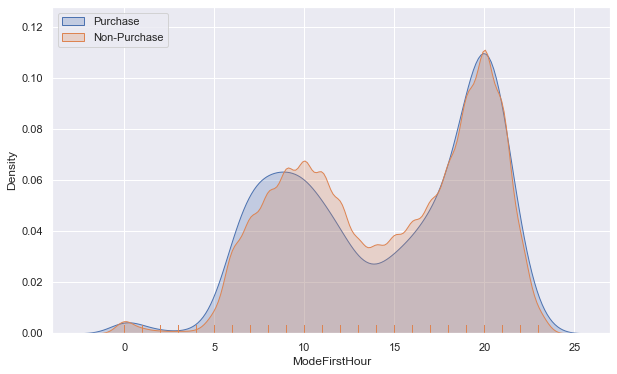

In [33]:
plt.figure(figsize=(10, 6))
sb.distplot(data.loc[data['Label'] == 1]['ModeFirstHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Purchase')
sb.distplot(data.loc[data['Label'] == 0]['ModeFirstHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Non-Purchase')
plt.legend(loc='upper left');

In [165]:
excludes = ['firstPaymentType', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 'TotalChild', 
            'MedianChildAge', 'No.Female', 'No.Male', 'No.TypeBrand', 'BigBrand', 'MediumBrand',
            'SmallBrand', 'Label', 'gapday', 'JoinMonth', 'ModeFirstHour', 'ModeLastHour', 'ModeLastDay',
            'ModeDayofweek']

for col in data.columns[1:]:
    if col not in excludes:
        if data[col].min() == 0:
            data[col] = data[col] + 1
            data[col] = np.log(data[col])
        else:
            data[col] = np.log(data[col])

In [166]:
data.to_csv('ICK_Active6thdays.csv', index=False)

----- TotalUsageTime -----
count    158981.000000
mean          2.730266
std           1.344249
min           0.000000
25%           1.667707
50%           2.781920
75%           3.725211
max           7.884061
Name: TotalUsageTime, dtype: float64
* Variance: 1.8070067132994585
* Median: 2.7819200496686656
* Skewness: 0.033551716815075815
* Kurtosis: -0.7483379196122724
* Percentage of outliers: 0.00011322107673243973
* Number of missing value: 0


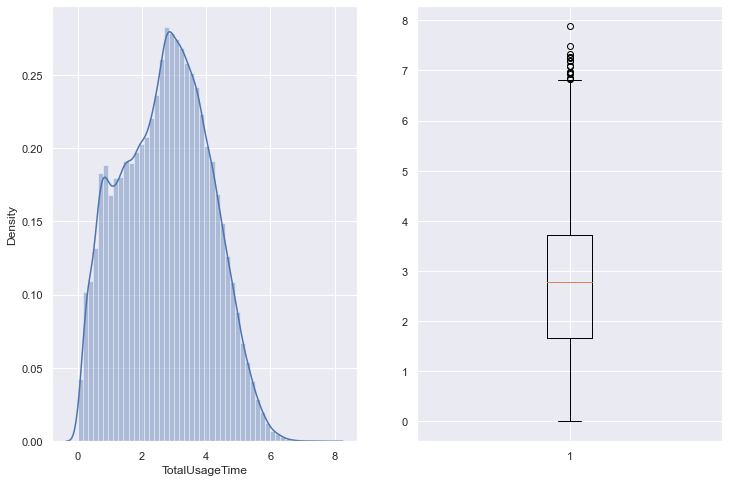


----- TotalRecords -----
count    158981.000000
mean          2.623218
std           1.368660
min           0.000000
25%           1.609438
50%           2.772589
75%           3.610918
max           7.086738
Name: TotalRecords, dtype: float64
* Variance: 1.873231376845245
* Median: 2.772588722239781
* Skewness: -0.16626978337370954
* Kurtosis: -0.636224898417808
* Percentage of outliers: 5.6610538366219865e-05
* Number of missing value: 0


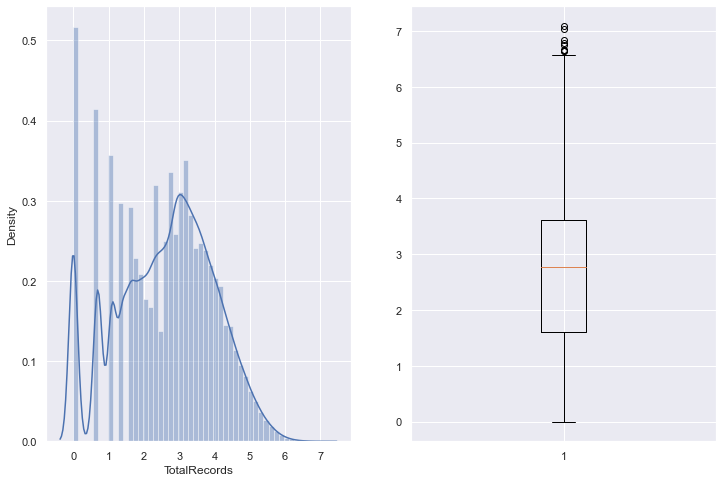


----- InteractionEnglish -----
count    158981.000000
mean          2.164881
std           2.490500
min           0.000000
25%           0.000000
50%           0.797507
75%           4.520375
max          12.124407
Name: InteractionEnglish, dtype: float64
* Variance: 6.202592060515886
* Median: 0.797507195884188
* Skewness: 0.6970007959360239
* Kurtosis: -0.934503560354397
* Percentage of outliers: 3.145029909234437e-05
* Number of missing value: 0


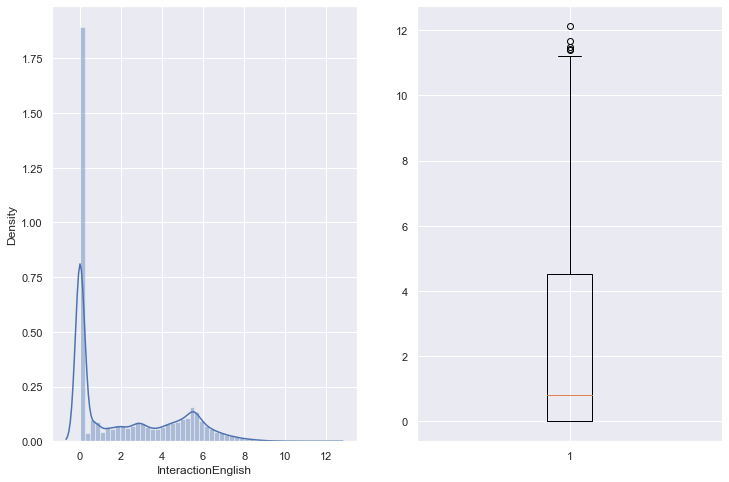


----- InteractionMath -----
count    158981.000000
mean          0.089390
std           0.649777
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          11.933905
Name: InteractionMath, dtype: float64
* Variance: 0.42220976633913904
* Median: 0.0
* Skewness: 8.517410012627817
* Kurtosis: 78.31066353481738
* Percentage of outliers: 0.029248778155880263
* Number of missing value: 0


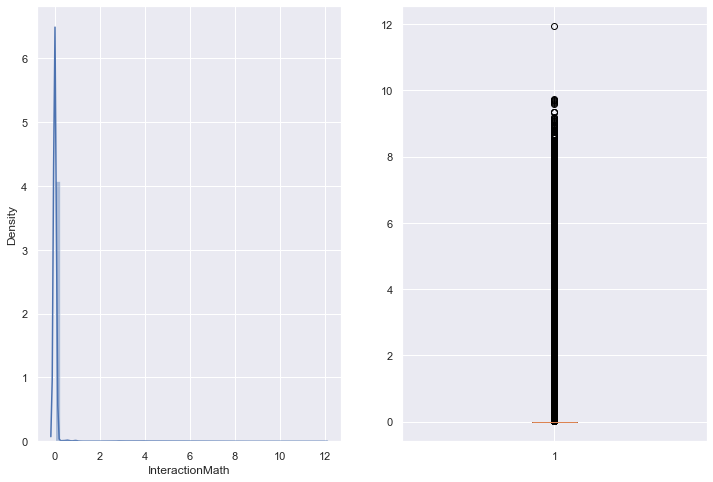


----- InteractionPhonics -----
count    158981.000000
mean          0.101718
std           0.655675
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.228379
Name: InteractionPhonics, dtype: float64
* Variance: 0.42990958756589676
* Median: 0.0
* Skewness: 7.492585627651091
* Kurtosis: 60.43123242589272
* Percentage of outliers: 0.03323038602097106
* Number of missing value: 0


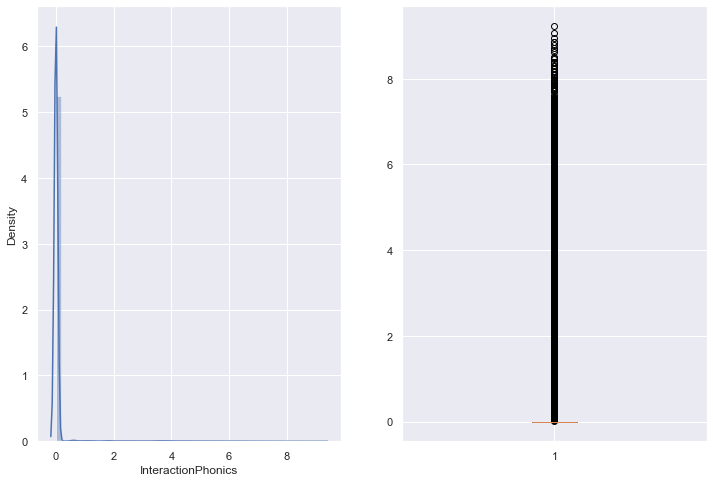


----- InteractionVietnamese -----
count    158981.000000
mean          2.303596
std           2.651412
min           0.000000
25%           0.000000
50%           0.896088
75%           4.596634
max          11.770268
Name: InteractionVietnamese, dtype: float64
* Variance: 7.029988074776632
* Median: 0.8960880245566357
* Skewness: 0.7574137872232465
* Kurtosis: -0.7965301891251877
* Percentage of outliers: 1.2580119636937746e-05
* Number of missing value: 0


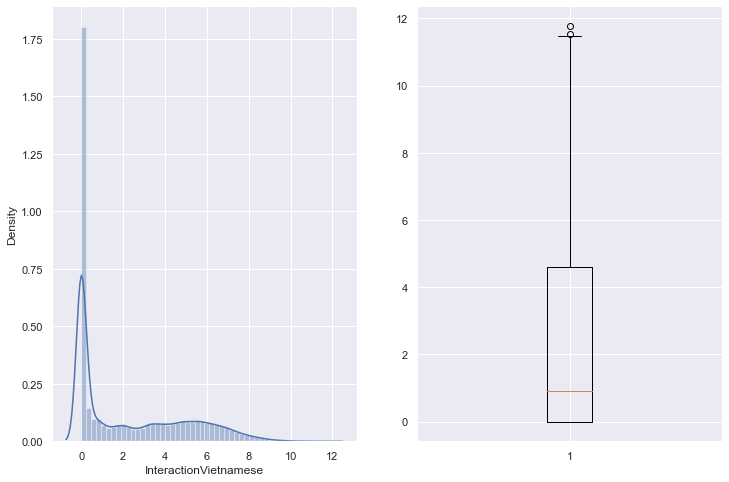


----- IsCompletedEnglish -----
count    158981.000000
mean          0.492984
std           0.522727
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           2.079442
Name: IsCompletedEnglish, dtype: float64
* Variance: 0.27324328491420175
* Median: 0.6931471805599453
* Skewness: 0.6215381327397359
* Kurtosis: -0.5885487425728018
* Percentage of outliers: 0.018687767720671024
* Number of missing value: 0


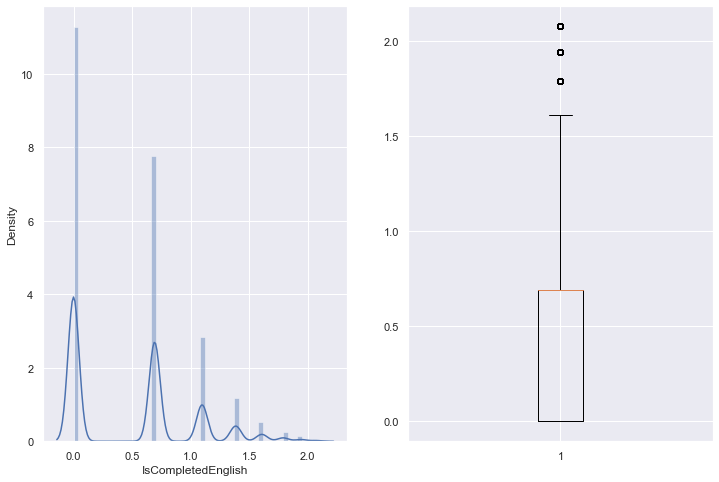


----- IsCompletedMath -----
count    158981.000000
mean          0.023921
std           0.152485
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.079442
Name: IsCompletedMath, dtype: float64
* Variance: 0.023251557596378238
* Median: 0.0
* Skewness: 7.133269379382015
* Kurtosis: 56.01687410560318
* Percentage of outliers: 0.026978066561412998
* Number of missing value: 0


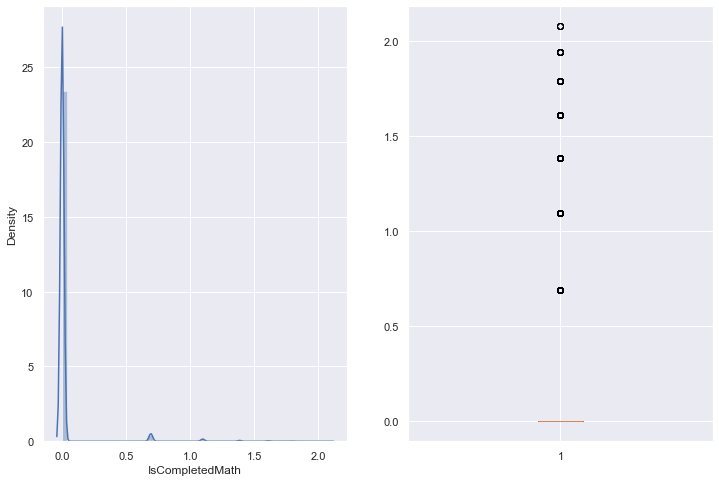


----- IsCompletedPhonics -----
count    158981.000000
mean          0.026285
std           0.156253
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.079442
Name: IsCompletedPhonics, dtype: float64
* Variance: 0.024414942611725884
* Median: 0.0
* Skewness: 6.554963167602412
* Kurtosis: 46.84784495448155
* Percentage of outliers: 0.030481629880300162
* Number of missing value: 0


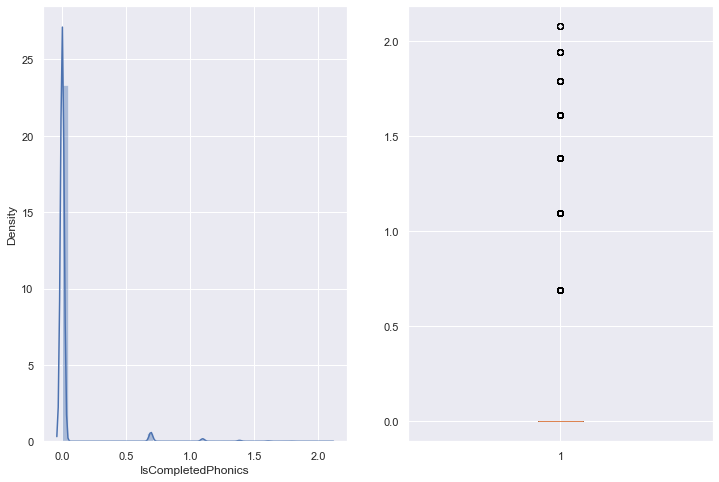


----- IsCompletedVietnamese -----
count    158981.000000
mean          0.515883
std           0.544004
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           2.079442
Name: IsCompletedVietnamese, dtype: float64
* Variance: 0.2959407020311574
* Median: 0.6931471805599453
* Skewness: 0.6566811865268992
* Kurtosis: -0.5015647674669408
* Percentage of outliers: 0.028852504387316725
* Number of missing value: 0


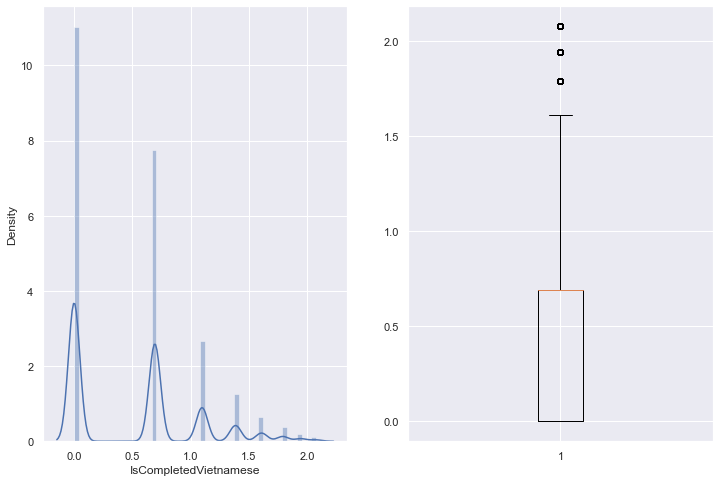


----- RecordEnglish -----
count    158981.000000
mean          1.362746
std           1.464204
min           0.000000
25%           0.000000
50%           1.098612
75%           2.708050
max           6.751101
Name: RecordEnglish, dtype: float64
* Variance: 2.1438942813386763
* Median: 1.0986122886681098
* Skewness: 0.5611763758814517
* Kurtosis: -1.025432904048158
* Percentage of outliers: 0.0
* Number of missing value: 0


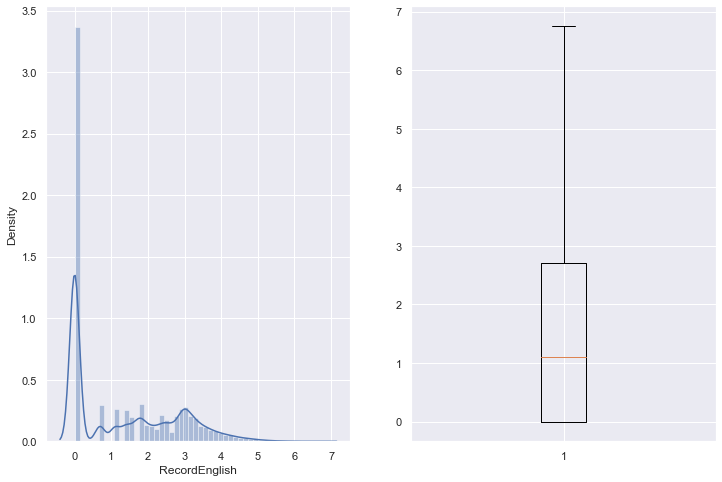


----- RecordMath -----
count    158981.000000
mean          0.058943
std           0.383239
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.560682
Name: RecordMath, dtype: float64
* Variance: 0.14687234758682532
* Median: 0.0
* Skewness: 7.503843761894547
* Kurtosis: 61.03645285982885
* Percentage of outliers: 0.0292613582755172
* Number of missing value: 0


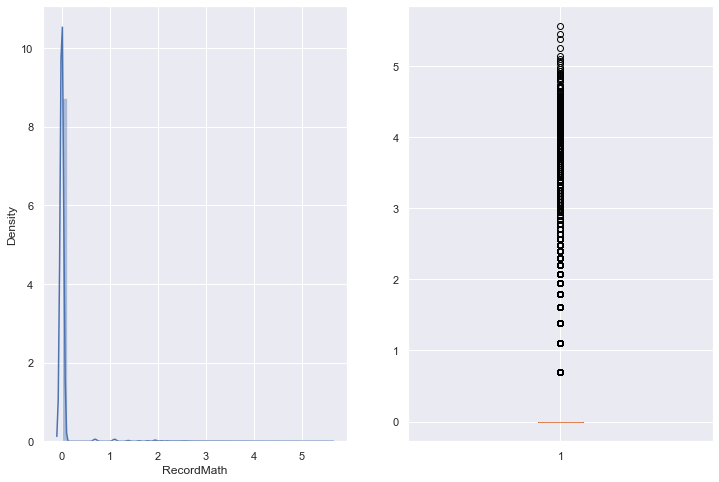


----- RecordPhonics -----
count    158981.000000
mean          0.065240
std           0.392321
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.564520
Name: RecordPhonics, dtype: float64
* Variance: 0.15391587722387884
* Median: 0.0
* Skewness: 6.871160127426968
* Kurtosis: 51.00882693349878
* Percentage of outliers: 0.033255546260244934
* Number of missing value: 0


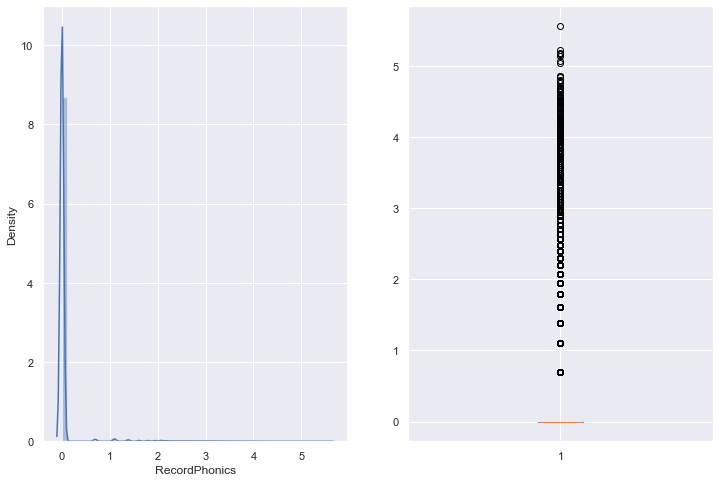


----- RecordVietnamese -----
count    158981.000000
mean          1.405096
std           1.492549
min           0.000000
25%           0.000000
50%           1.098612
75%           2.639057
max           6.720220
Name: RecordVietnamese, dtype: float64
* Variance: 2.2277023206379867
* Median: 1.0986122886681098
* Skewness: 0.6735717344088078
* Kurtosis: -0.7515326517026204
* Percentage of outliers: 1.887017945540662e-05
* Number of missing value: 0


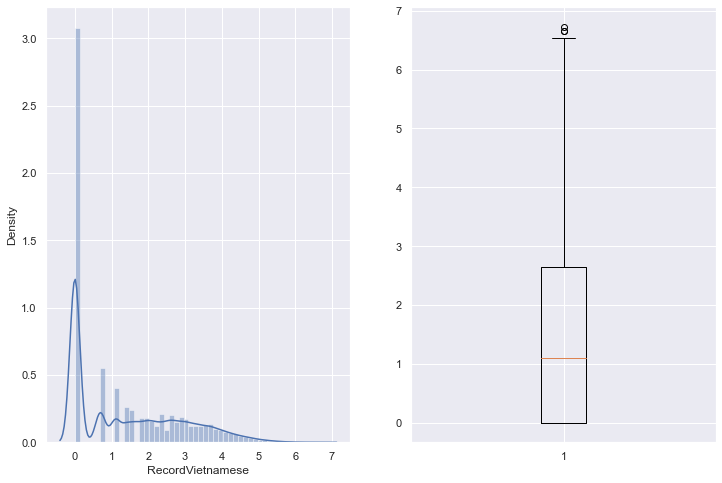


----- UsageTimeEnglish -----
count    158981.000000
mean          1.206848
std           1.352119
min           0.000000
25%           0.000000
50%           0.751416
75%           2.420368
max           7.300318
Name: UsageTimeEnglish, dtype: float64
* Variance: 1.828224515892635
* Median: 0.7514160886839212
* Skewness: 0.7154109956659512
* Kurtosis: -0.7103724055164116
* Percentage of outliers: 0.00015725149546172185
* Number of missing value: 0


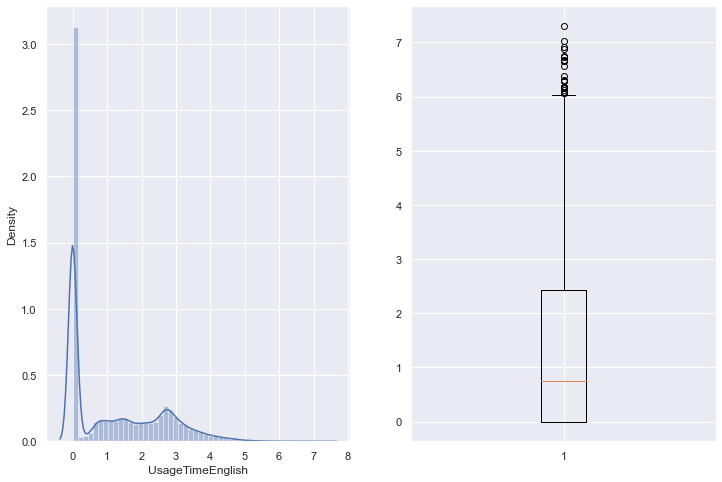


----- UsageTimeMath -----
count    158981.000000
mean          0.052563
std           0.373368
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.771961
Name: UsageTimeMath, dtype: float64
* Variance: 0.13940376791304998
* Median: 0.0
* Skewness: 8.540772017231829
* Kurtosis: 80.39448887266322
* Percentage of outliers: 0.029248778155880263
* Number of missing value: 0


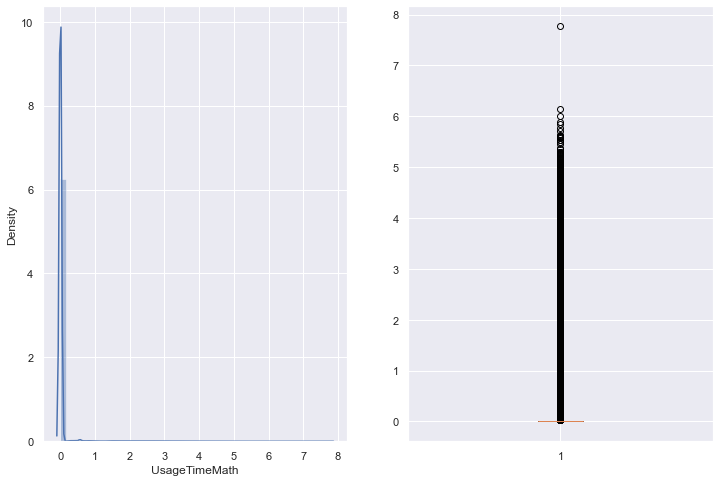


----- UsageTimePhonics -----
count    158981.000000
mean          0.062786
std           0.385357
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.390213
Name: UsageTimePhonics, dtype: float64
* Variance: 0.14850028286957492
* Median: 0.0
* Skewness: 7.034532849610235
* Kurtosis: 53.488001385521635
* Percentage of outliers: 0.03323038602097106
* Number of missing value: 0


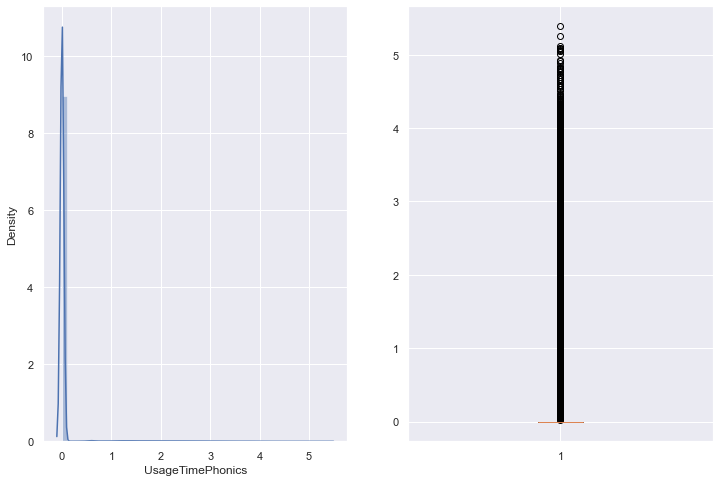


----- UsageTimeVietnamese -----
count    158981.000000
mean          1.321893
std           1.462345
min           0.000000
25%           0.000000
50%           0.765468
75%           2.537657
max           6.737584
Name: UsageTimeVietnamese, dtype: float64
* Variance: 2.1384537635425573
* Median: 0.7654678421395714
* Skewness: 0.7238437963515677
* Kurtosis: -0.729791571851766
* Percentage of outliers: 6.919065800315761e-05
* Number of missing value: 0


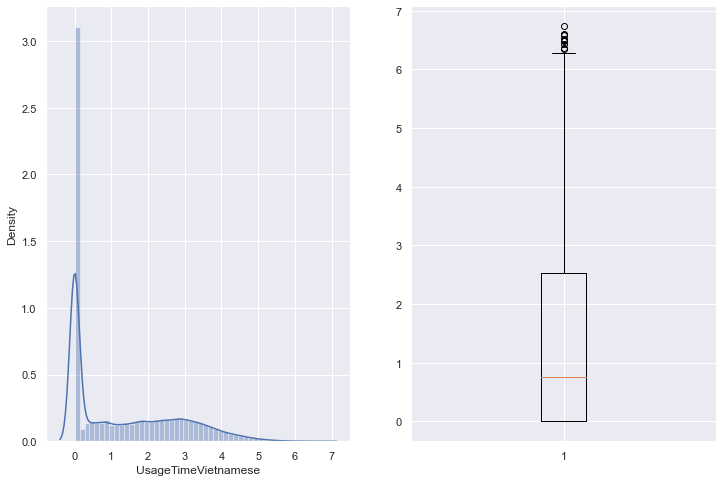


----- RecordDiscovery -----
count    158981.000000
mean          0.672615
std           0.930038
min           0.000000
25%           0.000000
50%           0.000000
75%           1.386294
max           5.303305
Name: RecordDiscovery, dtype: float64
* Variance: 0.8649703476624523
* Median: 0.0
* Skewness: 1.1677264612224443
* Kurtosis: 0.24245392573598545
* Percentage of outliers: 0.005101238512778257
* Number of missing value: 0


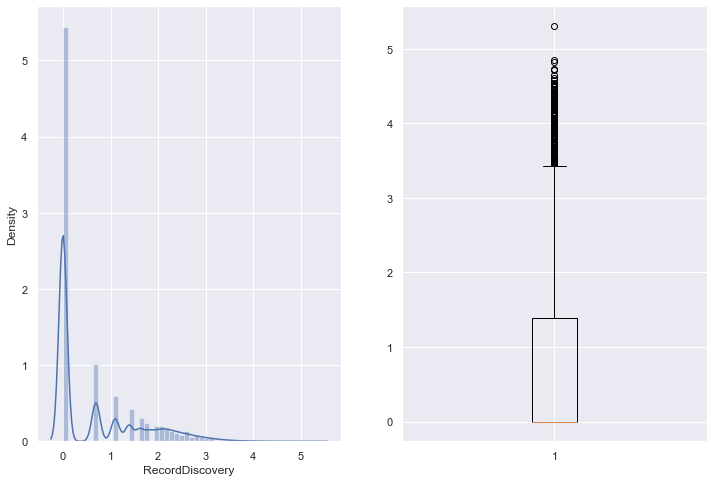


----- RecordEntertainment -----
count    158981.000000
mean          0.811909
std           1.107142
min           0.000000
25%           0.000000
50%           0.000000
75%           1.609438
max           6.293419
Name: RecordEntertainment, dtype: float64
* Variance: 1.2257625384475965
* Median: 0.0
* Skewness: 1.2320424824867144
* Kurtosis: 0.6109341024574153
* Percentage of outliers: 0.009862813795359193
* Number of missing value: 0


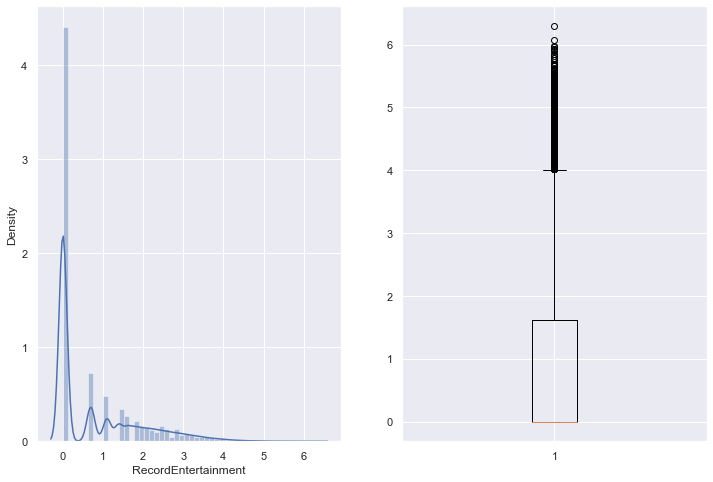


----- RecordLearn -----
count    158981.000000
mean          2.466981
std           1.277900
min           0.000000
25%           1.386294
50%           2.564949
75%           3.367296
max           6.988413
Name: RecordLearn, dtype: float64
* Variance: 1.6330288723128692
* Median: 2.5649493574615367
* Skewness: 0.005259090301601942
* Kurtosis: -0.619536042149404
* Percentage of outliers: 0.00015096143564325296
* Number of missing value: 0


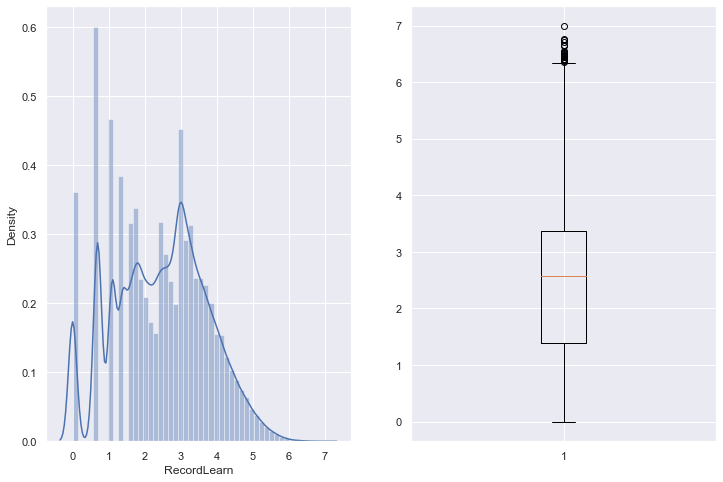


----- UsageTimeDiscovery -----
count    158981.000000
mean          0.871244
std           1.244914
min           0.000000
25%           0.000000
50%           0.000000
75%           1.783391
max           6.211624
Name: UsageTimeDiscovery, dtype: float64
* Variance: 1.5498100266356418
* Median: 0.0
* Skewness: 1.111779443762455
* Kurtosis: -0.14886548484640638
* Percentage of outliers: 0.0031639000886898435
* Number of missing value: 0


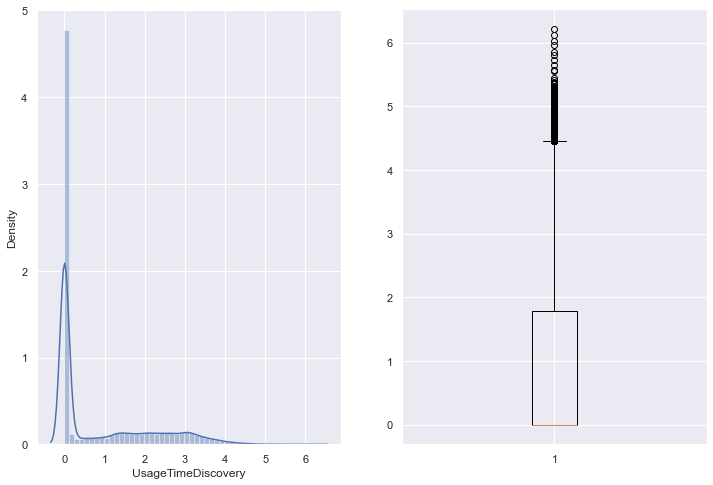


----- UsageTimeEntertainment -----
count    158981.000000
mean          0.912333
std           1.358569
min           0.000000
25%           0.000000
50%           0.000000
75%           1.677097
max           7.171073
Name: UsageTimeEntertainment, dtype: float64
* Variance: 1.8457086230949897
* Median: 0.0
* Skewness: 1.37313143110501
* Kurtosis: 0.784087017811173
* Percentage of outliers: 0.031142086161239393
* Number of missing value: 0


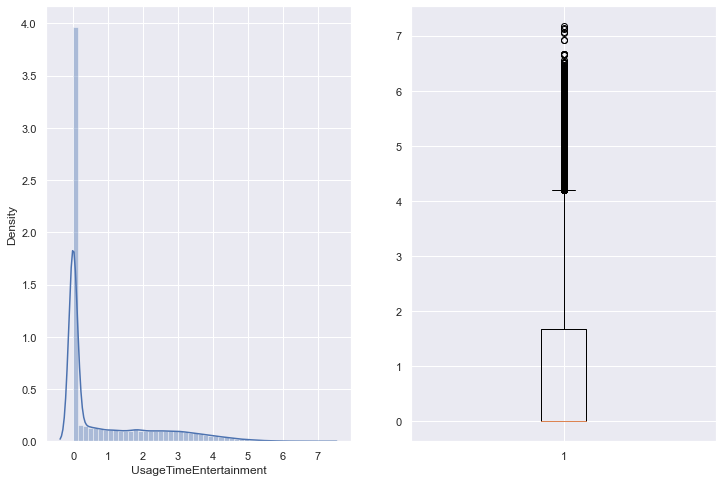


----- UsageTimeLearn -----
count    158981.000000
mean          2.272278
std           1.286637
min           0.000000
25%           1.247032
50%           2.354228
75%           3.192532
max           7.793310
Name: UsageTimeLearn, dtype: float64
* Variance: 1.6554349481250503
* Median: 2.354228326145884
* Skewness: 0.0744644616155259
* Kurtosis: -0.679637883024411
* Percentage of outliers: 0.0004088538882004768
* Number of missing value: 0


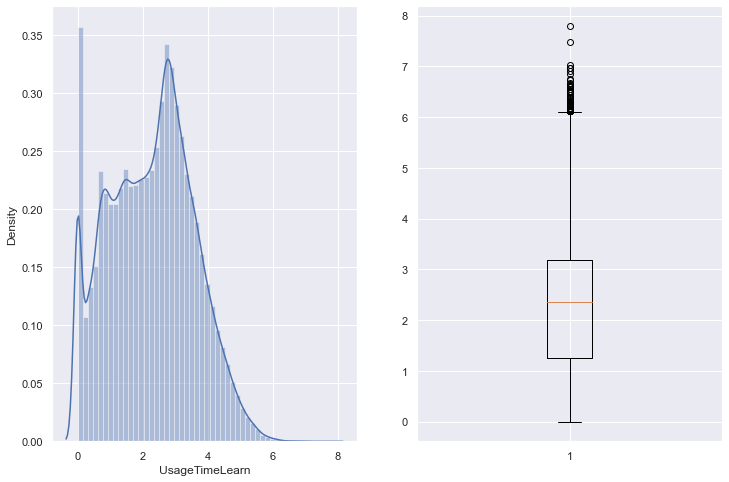


----- MedianUsageTime -----
count    158981.000000
mean          1.833831
std           0.811448
min           0.000000
25%           1.232560
50%           1.871802
75%           2.433613
max           5.357435
Name: MedianUsageTime, dtype: float64
* Variance: 0.6584480658715312
* Median: 1.8718021769015913
* Skewness: -0.02712535453828789
* Kurtosis: -0.572359846365742
* Percentage of outliers: 0.0009686692120442065
* Number of missing value: 0


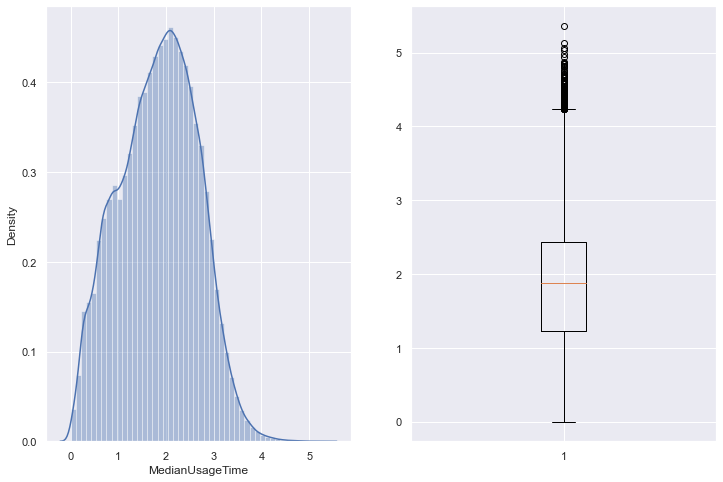


----- MedianRecord -----
count    158981.000000
mean          1.599185
std           0.904734
min           0.000000
25%           1.098612
50%           1.609438
75%           2.251292
max           5.231109
Name: MedianRecord, dtype: float64
* Variance: 0.8185433884190891
* Median: 1.6094379124341003
* Skewness: -0.023429337263405885
* Kurtosis: -0.5573225918204723
* Percentage of outliers: 0.0018995980651775998
* Number of missing value: 0


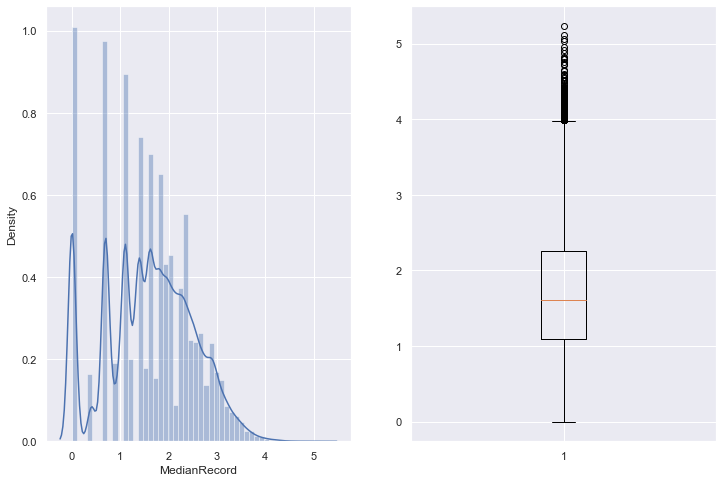


----- MedianPaymentScreen -----
count    158981.000000
mean          0.449716
std           0.650814
min           0.000000
25%           0.000000
50%           0.000000
75%           0.693147
max           5.209486
Name: MedianPaymentScreen, dtype: float64
* Variance: 0.4235590045811229
* Median: 0.0
* Skewness: 1.4499251135879254
* Kurtosis: 1.7317854959246195
* Percentage of outliers: 0.056497317289487425
* Number of missing value: 0


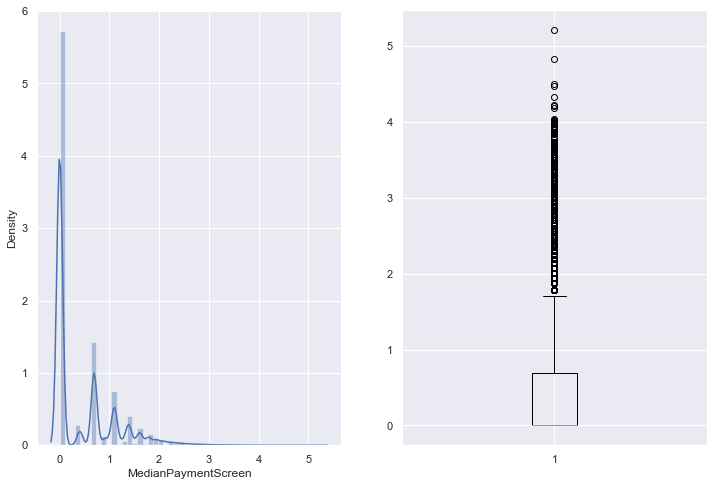


----- AvgTimePerCompletion -----
count    158981.000000
mean          0.682741
std           0.255638
min           0.000000
25%           0.527355
50%           0.641672
75%           0.806213
max           4.224934
Name: AvgTimePerCompletion, dtype: float64
* Variance: 0.06535098615675632
* Median: 0.6416723814981511
* Skewness: 1.0941935950266477
* Kurtosis: 3.282417335046865
* Percentage of outliers: 0.04060862618803505
* Number of missing value: 0


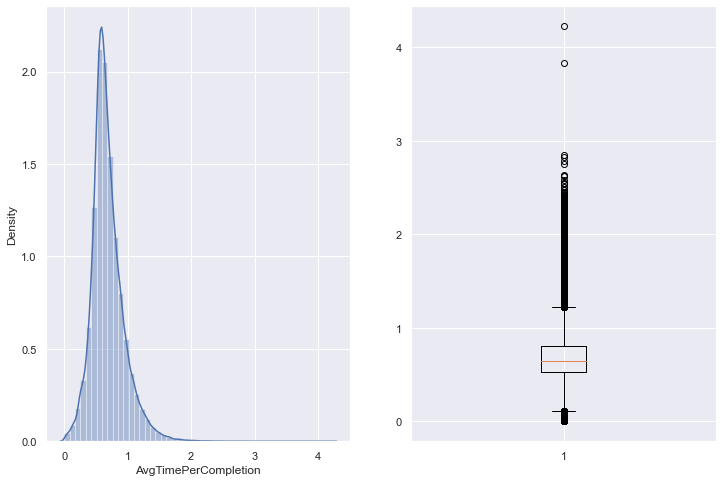


----- InteractionGeneral -----
count    158981.000000
mean          5.270563
std           2.735319
min           0.000000
25%           3.138966
50%           5.498643
75%           7.305954
max          14.372449
Name: InteractionGeneral, dtype: float64
* Variance: 7.4819707079736215
* Median: 5.498642547781566
* Skewness: -0.05211234523110348
* Kurtosis: -0.7878973357605554
* Percentage of outliers: 3.774035891081324e-05
* Number of missing value: 0


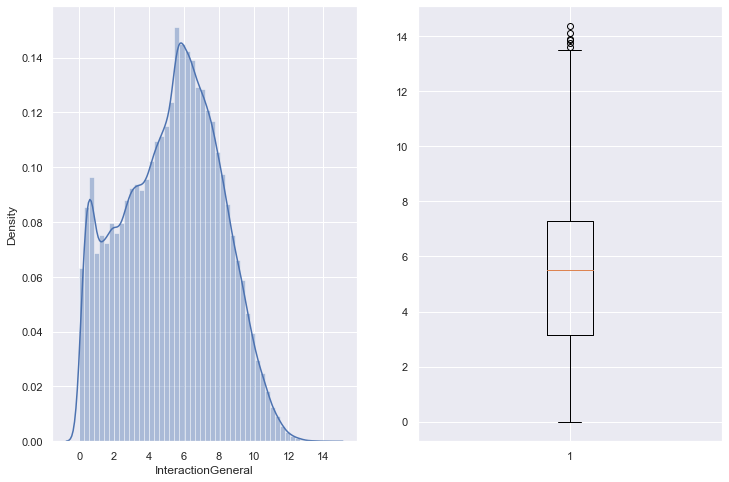


----- InteractionLearn -----
count    158981.000000
mean          4.491468
std           2.718531
min           0.000000
25%           2.234306
50%           4.708178
75%           6.475433
max          14.119593
Name: InteractionLearn, dtype: float64
* Variance: 7.390412110686981
* Median: 4.70817793606232
* Skewness: 0.045306232271685364
* Kurtosis: -0.8340167166539292
* Percentage of outliers: 0.00011322107673243973
* Number of missing value: 0


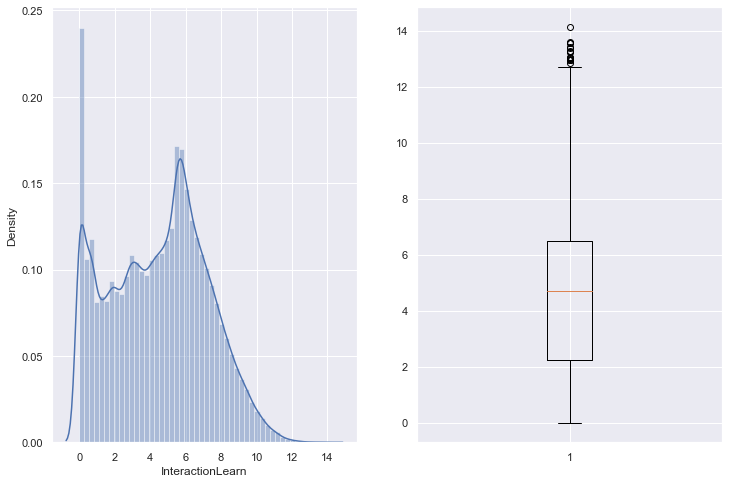


----- InteractionDiscovery -----
count    158981.000000
mean          1.373887
std           2.086277
min           0.000000
25%           0.000000
50%           0.000000
75%           2.571849
max          10.919164
Name: InteractionDiscovery, dtype: float64
* Variance: 4.352551493804676
* Median: 0.0
* Skewness: 1.3314662748599269
* Kurtosis: 0.5152942895304893
* Percentage of outliers: 0.026550342493757116
* Number of missing value: 0


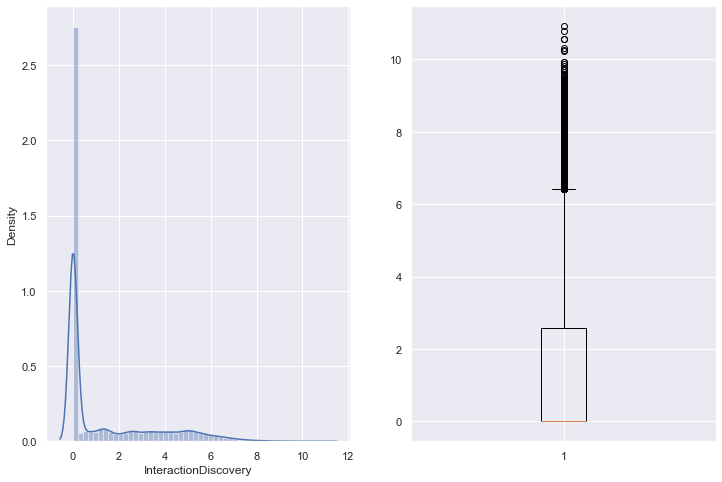


----- InteractionEntertainment -----
count    158981.000000
mean          1.549093
std           2.386581
min           0.000000
25%           0.000000
50%           0.000000
75%           2.738256
max          13.057707
Name: InteractionEntertainment, dtype: float64
* Variance: 5.6957669424312165
* Median: 0.0
* Skewness: 1.4708455083677647
* Kurtosis: 1.1319828548119975
* Percentage of outliers: 0.04701819714305483
* Number of missing value: 0


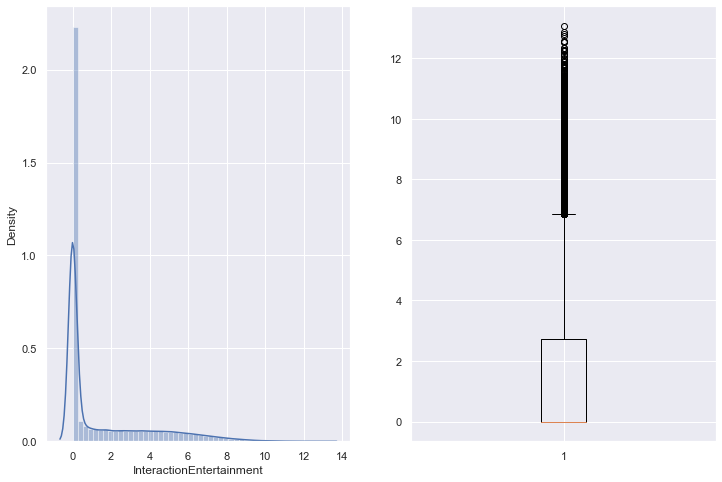


----- MedianInteraction -----
count    158981.000000
mean          3.309983
std           1.680370
min           0.000000
25%           2.028148
50%           3.363842
75%           4.542497
max          10.043499
Name: MedianInteraction, dtype: float64
* Variance: 2.8236445765949667
* Median: 3.3638415951183864
* Skewness: 0.04170644970218177
* Kurtosis: -0.6587962157527683
* Percentage of outliers: 0.0007170668193054516
* Number of missing value: 0


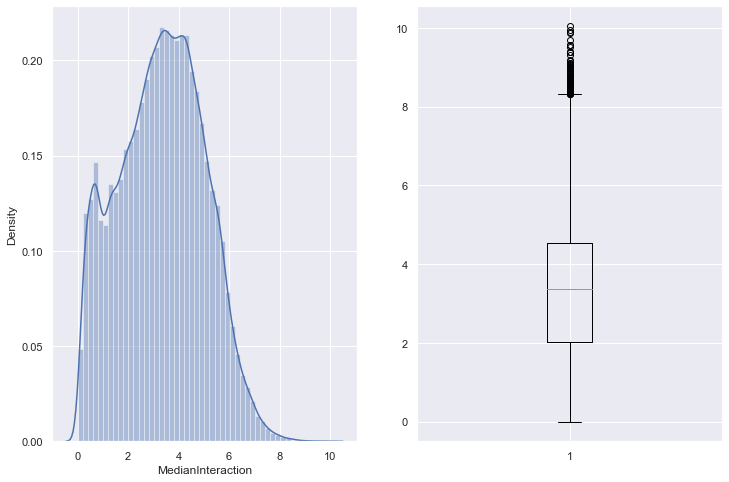

In [35]:
for col in data.columns[1:]:
    if col not in excludes:
        fc.continuous_analysis(data, col)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UserID                    158981 non-null  object 
 1   Recency                   158981 non-null  int64  
 2   ContentFrequent           158981 non-null  int64  
 3   PaymentScreenFrequent     158981 non-null  int64  
 4   TotalUsageTime            158981 non-null  float64
 5   TotalRecords              158981 non-null  float64
 6   ModeFirstHour             158981 non-null  int64  
 7   ModeLastHour              158981 non-null  int64  
 8   ModeLastDay               158981 non-null  int64  
 9   ModeDayofweek             158981 non-null  int64  
 10  TotalChild                158981 non-null  float64
 11  MedianChildAge            158981 non-null  float64
 12  No.Female                 158981 non-null  float64
 13  No.Male                   158981 non-null  f

In [37]:
data

,UserID,Recency,ContentFrequent,PaymentScreenFrequent,TotalUsageTime,TotalRecords,ModeFirstHour,ModeLastHour,ModeLastDay,ModeDayofweek,...,firstPaymentType,JoinMonth,gapday,AvgTimePerCompletion,InteractionGeneral,InteractionLearn,InteractionDiscovery,InteractionEntertainment,MedianInteraction,Label
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,7,1,0,2.927453,2.890372,22,22,11,0,...,NaN,7.0,NaN,0.684219,5.765943,5.765943,0.000000,0.00000,5.765943,0
1,00007f9f-be36-4a0d-a2a8-167231588625,7,1,0,2.060514,1.098612,18,18,12,1,...,NaN,4.0,NaN,1.188859,3.070376,0.000000,3.070376,0.00000,3.070376,0
2,00015787-1ed9-45b9-9c5f-2613e2ca8409,1,14,79,5.346869,5.298317,18,20,18,0,...,NaN,4.0,NaN,0.715276,10.640436,8.902477,8.296547,7.94930,4.155753,0
3,0001f256-edcf-4980-b84b-85d85745fd0f,6,3,0,3.774139,4.110874,8,20,22,4,...,NaN,7.0,NaN,0.529277,7.862174,7.830744,0.488580,0.00000,5.845108,0
4,000234a9-a233-4476-9023-9b83f331b7f6,7,2,0,2.746630,3.295837,18,18,16,6,...,NaN,4.0,NaN,0.432023,5.978709,5.922436,0.239017,0.00000,4.599982,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163035,fffdf7d4-a6c3-46e6-bbb7-045211d7007f,7,1,0,0.392042,0.000000,21,21,13,0,...,NaN,6.0,NaN,0.392042,0.392042,0.392042,0.000000,0.00000,0.392042,0
163036,ffff2125-692f-4755-bfcd-59219e49d6d6,7,1,1,1.613430,1.609438,20,21,12,6,...,NaN,6.0,NaN,0.590006,3.049273,3.049273,0.000000,0.00000,3.049273,0
163037,ffff56de-effe-4b67-9990-33240f51c866,7,2,2,1.418277,1.791759,20,20,3,6,...,NaN,7.0,NaN,0.419806,2.984671,2.656757,0.392042,0.00000,1.739589,0
163038,ffff81a7-4938-4d26-8492-bd8e4acc2a19,5,4,0,3.960051,3.367296,12,12,24,4,...,NaN,6.0,NaN,1.020464,7.308771,2.132982,4.107590,6.61962,3.694302,0


In [38]:
X = data.drop(['UserID', 'Label', 'firstPaymentType', 'gapday'], axis = 1)
y = data['Label']

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [40]:
def ScaleData(train_data, test_data, method=None):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
    if method==None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'min_max':
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'robust':
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [41]:
X_train_norm, X_test_norm = ScaleData(X_train, X_test, method=None)
X_train_mm, X_test_mm = ScaleData(X_train, X_test, method='min_max')
X_train_rb, X_test_rb = ScaleData(X_train, X_test, method='robust')

In [42]:
sw = fc.BinarySampleWeights(X_train.shape[0], y_train)
sw_zen = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'zen')
sw_isns = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'isns')
sw_eff = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'ens', beta = 0.99999)

In [43]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9453940747263807

In [44]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9454

* Confusion Matrix: 
[[29575   162]
 [ 1573   487]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29737
           1       0.75      0.24      0.36      2060

    accuracy                           0.95     31797
   macro avg       0.85      0.62      0.67     31797
weighted avg       0.94      0.95      0.93     31797



In [45]:
logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train_norm, y_train)

logit_model.score(X_train_norm, y_train)

0.9464319411246698

In [46]:
fc.eval_clf_testset(logit_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9468

* Confusion Matrix: 
[[29579   158]
 [ 1533   527]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29737
           1       0.77      0.26      0.38      2060

    accuracy                           0.95     31797
   macro avg       0.86      0.63      0.68     31797
weighted avg       0.94      0.95      0.93     31797



In [47]:
import lightgbm as lgbm

lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 100,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9381919109321927

In [48]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.932

* Confusion Matrix: 
[[28402  1335]
 [  827  1233]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     29737
           1       0.48      0.60      0.53      2060

    accuracy                           0.93     31797
   macro avg       0.73      0.78      0.75     31797
weighted avg       0.94      0.93      0.94     31797



In [51]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 600,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.970609510630268

In [52]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9406

* Confusion Matrix: 
[[28788   949]
 [  940  1120]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.54      0.54      0.54      2060

    accuracy                           0.94     31797
   macro avg       0.75      0.76      0.76     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7559


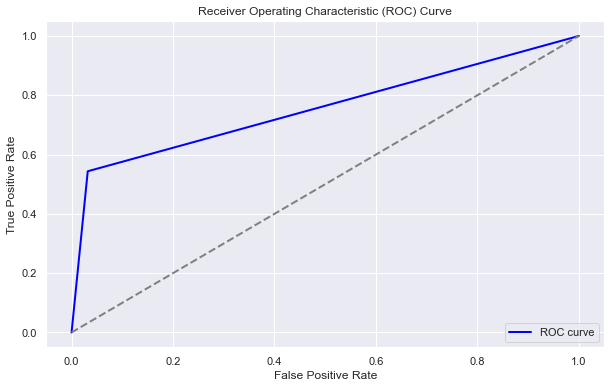

In [53]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test)) 

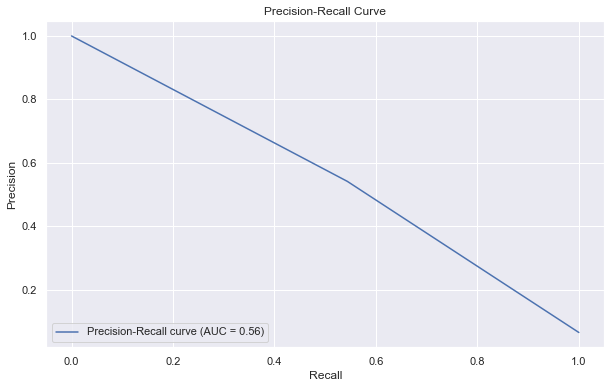

In [55]:
fc.plot_precision_recall_curve(lgbm_model, X_test, y_test)

In [66]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=6,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3
                              )

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9302663857088942

In [67]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9236

* Confusion Matrix: 
[[28074  1663]
 [  765  1295]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     29737
           1       0.44      0.63      0.52      2060

    accuracy                           0.92     31797
   macro avg       0.71      0.79      0.74     31797
weighted avg       0.94      0.92      0.93     31797



ROC AUC score: 0.7864


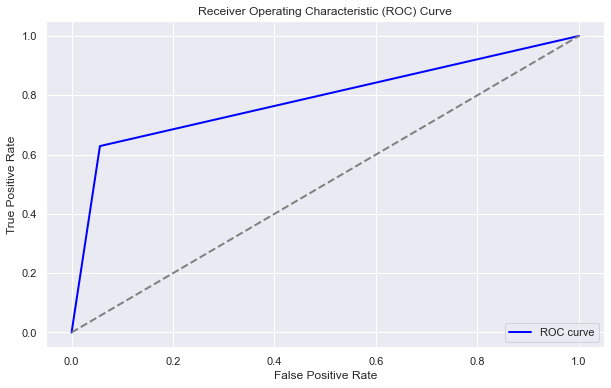

In [68]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [89]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=7,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9652550635300038

In [90]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9351

* Confusion Matrix: 
[[28528  1209]
 [  855  1205]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     29737
           1       0.50      0.58      0.54      2060

    accuracy                           0.94     31797
   macro avg       0.74      0.77      0.75     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7721


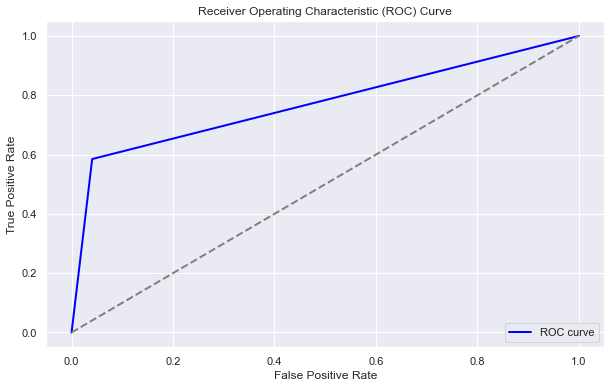

In [91]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [157]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3
                              )

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9429487985910178

In [158]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9395

* Confusion Matrix: 
[[28703  1034]
 [  891  1169]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.53      0.57      0.55      2060

    accuracy                           0.94     31797
   macro avg       0.75      0.77      0.76     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7664


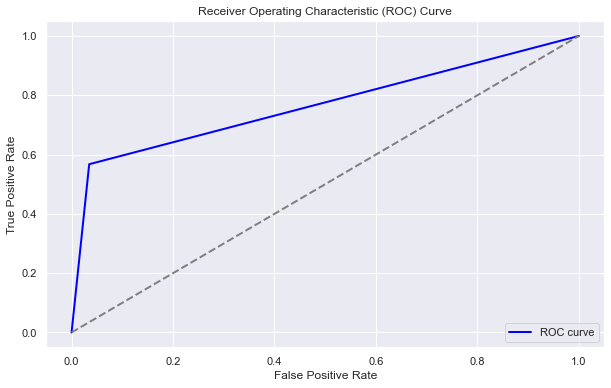

In [100]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [103]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9650427726758083

In [104]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9396

* Confusion Matrix: 
[[28720  1017]
 [  905  1155]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.53      0.56      0.55      2060

    accuracy                           0.94     31797
   macro avg       0.75      0.76      0.76     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7632


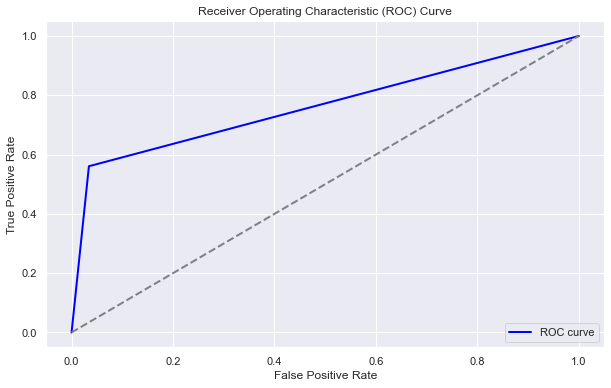

In [105]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [106]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8675226443577808

In [107]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8624

* Confusion Matrix: 
[[25883  3854]
 [  522  1538]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     29737
           1       0.29      0.75      0.41      2060

    accuracy                           0.86     31797
   macro avg       0.63      0.81      0.67     31797
weighted avg       0.94      0.86      0.89     31797



ROC AUC score: 0.8085


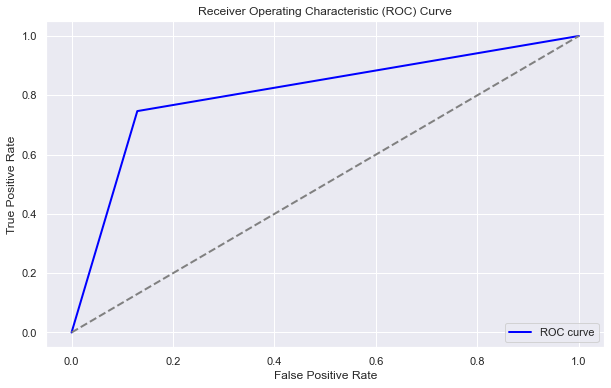

In [108]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [109]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=15,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8580403195370487

In [110]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8546

* Confusion Matrix: 
[[25617  4120]
 [  503  1557]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     29737
           1       0.27      0.76      0.40      2060

    accuracy                           0.85     31797
   macro avg       0.63      0.81      0.66     31797
weighted avg       0.93      0.85      0.88     31797



ROC AUC score: 0.8086


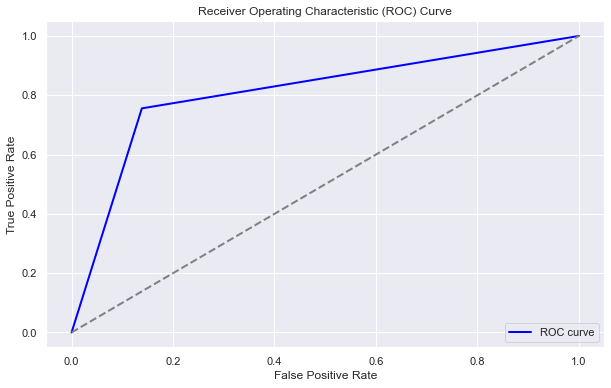

In [111]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [112]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()

gauss_model = gauss.fit(X_train, y_train)
gauss_model.score(X_train, y_train)

0.8125157252484589

In [113]:
fc.eval_clf_testset(gauss_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8124

* Confusion Matrix: 
[[24490  5247]
 [  718  1342]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     29737
           1       0.20      0.65      0.31      2060

    accuracy                           0.81     31797
   macro avg       0.59      0.74      0.60     31797
weighted avg       0.92      0.81      0.85     31797



In [114]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 42)

tree_clf = tree.fit(X_train, y_train)
tree_clf.score(X_train, y_train)

1.0

In [115]:
fc.eval_clf_testset(tree_clf, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9138

* Confusion Matrix: 
[[28247  1490]
 [ 1251   809]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     29737
           1       0.35      0.39      0.37      2060

    accuracy                           0.91     31797
   macro avg       0.65      0.67      0.66     31797
weighted avg       0.92      0.91      0.92     31797



In [116]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.8038432507233614

In [117]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8022

* Confusion Matrix: 
[[23958  5779]
 [  511  1549]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.81      0.88     29737
           1       0.21      0.75      0.33      2060

    accuracy                           0.80     31797
   macro avg       0.60      0.78      0.61     31797
weighted avg       0.93      0.80      0.85     31797



In [118]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.8052663857088942

In [119]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8034

* Confusion Matrix: 
[[24009  5728]
 [  524  1536]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.81      0.88     29737
           1       0.21      0.75      0.33      2060

    accuracy                           0.80     31797
   macro avg       0.60      0.78      0.61     31797
weighted avg       0.93      0.80      0.85     31797



In [120]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9242043024279784

In [121]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9249

* Confusion Matrix: 
[[28366  1371]
 [ 1017  1043]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.43      0.51      0.47      2060

    accuracy                           0.92     31797
   macro avg       0.70      0.73      0.71     31797
weighted avg       0.93      0.92      0.93     31797



In [122]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.866437602214115

In [123]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8676

* Confusion Matrix: 
[[26212  3525]
 [  685  1375]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.88      0.93     29737
           1       0.28      0.67      0.40      2060

    accuracy                           0.87     31797
   macro avg       0.63      0.77      0.66     31797
weighted avg       0.93      0.87      0.89     31797



In [124]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [125]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9191

* Confusion Matrix: 
[[28437  1300]
 [ 1272   788]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.38      0.38      0.38      2060

    accuracy                           0.92     31797
   macro avg       0.67      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



In [126]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [127]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9195

* Confusion Matrix: 
[[28430  1307]
 [ 1254   806]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.38      0.39      0.39      2060

    accuracy                           0.92     31797
   macro avg       0.67      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



In [128]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [129]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9179

* Confusion Matrix: 
[[28401  1336]
 [ 1273   787]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.37      0.38      0.38      2060

    accuracy                           0.92     31797
   macro avg       0.66      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



In [131]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [132]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9174

* Confusion Matrix: 
[[28365  1372]
 [ 1255   805]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     29737
           1       0.37      0.39      0.38      2060

    accuracy                           0.92     31797
   macro avg       0.66      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



In [133]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42, n_estimators = 100)
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999764121273116

In [134]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9518

* Confusion Matrix: 
[[29589   148]
 [ 1385   675]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.97     29737
           1       0.82      0.33      0.47      2060

    accuracy                           0.95     31797
   macro avg       0.89      0.66      0.72     31797
weighted avg       0.95      0.95      0.94     31797



In [135]:
forest = RandomForestClassifier(random_state = 42, n_estimators = 100, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999685495030821

In [136]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9518

* Confusion Matrix: 
[[29626   111]
 [ 1421   639]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     29737
           1       0.85      0.31      0.45      2060

    accuracy                           0.95     31797
   macro avg       0.90      0.65      0.71     31797
weighted avg       0.95      0.95      0.94     31797



In [137]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 600,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9457007170713297

In [138]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9413

* Confusion Matrix: 
[[28769   968]
 [  899  1161]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.55      0.56      0.55      2060

    accuracy                           0.94     31797
   macro avg       0.76      0.77      0.76     31797
weighted avg       0.94      0.94      0.94     31797



In [139]:
data.to_csv('ICK_Active6thdays.csv', index=False)

In [140]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

In [141]:
class_weights_dict = dict(enumerate(class_weights))

In [142]:
class_weights_dict

{0: 0.5346379160753559, 1: 7.717524271844661}

In [143]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = class_weights_dict,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8637249968549503

In [144]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8596

* Confusion Matrix: 
[[25792  3945]
 [  520  1540]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     29737
           1       0.28      0.75      0.41      2060

    accuracy                           0.86     31797
   macro avg       0.63      0.81      0.66     31797
weighted avg       0.93      0.86      0.89     31797



In [145]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.9661671279406214

In [146]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9528

* Confusion Matrix: 
[[29508   229]
 [ 1273   787]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     29737
           1       0.77      0.38      0.51      2060

    accuracy                           0.95     31797
   macro avg       0.87      0.69      0.74     31797
weighted avg       0.95      0.95      0.95     31797



In [147]:
xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 900,
                            colsample_bytree=0.5646751146007976,
                            learning_rate=0.1419865761603358,
                            max_bin=824,
                            scale_pos_weight=5,
                            min_child_weight=1,
                            reg_alpha=1.6259583347890365e-07,
                            reg_lambda=2.110691851528507e-08,
                            subsample=0.879020578464637,
                            objective='binary:logistic',
                            max_depth=3,
                            n_jobs=-1,
                            verbosity=0)

xgb_model = xgb_clf.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.9453233111083155

In [148]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9326

* Confusion Matrix: 
[[28445  1292]
 [  850  1210]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     29737
           1       0.48      0.59      0.53      2060

    accuracy                           0.93     31797
   macro avg       0.73      0.77      0.75     31797
weighted avg       0.94      0.93      0.94     31797



In [149]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy='minority')

X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

In [150]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               scale_pos_weight=5)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9953843825665859

In [151]:
fc.eval_clf_testset(lgbm_model, X_train, y_train)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9914

* Confusion Matrix: 
[[118137    807]
 [   289   7951]]

* Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    118944
           1       0.91      0.96      0.94      8240

    accuracy                           0.99    127184
   macro avg       0.95      0.98      0.97    127184
weighted avg       0.99      0.99      0.99    127184



In [152]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9431

* Confusion Matrix: 
[[28941   796]
 [ 1012  1048]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.57      0.51      0.54      2060

    accuracy                           0.94     31797
   macro avg       0.77      0.74      0.75     31797
weighted avg       0.94      0.94      0.94     31797



In [153]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1000,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9536714756524078

In [154]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9133

* Confusion Matrix: 
[[27704  2033]
 [  725  1335]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     29737
           1       0.40      0.65      0.49      2060

    accuracy                           0.91     31797
   macro avg       0.69      0.79      0.72     31797
weighted avg       0.94      0.91      0.92     31797

